<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - Classify Posts from Reddit

# Background

Reddit is a very large and popular forum, with users across different countries and topics one can not even think of. There are many subreddits, which are communities for like minded people to post and share knowledge and information. Among these subreddits are 'aliens' and 'space'.

## Problem Statement

Men In Black (MIB) is a secret association that researches & monitors the sentiment of people on aliens, whether conspiracies that are made are a little too close to things that the people should not know about. Think area 51 and the roswell incident. But, nothing is fullproof. Things get leaked out anyway. They are usually leaked to r/aliens and r/space.  Instead of completely shutting down reddit, having a subreddit like aliens would be useful for MIB to monitor what people are talking about. They they are requesting us, the Reddit Data Science team to create a model to classify reddit posts and identify the key words that differentiates the post from "Aliens" to "Space". <br><br>

This will not only filter out posts from r/space that should belong to r/aliens, it will also facilitate MIB's intelligence collection efforts about sentiments from ordinary citizens. This information can also be useful for other associations to promote its marketing effort on social media, events and podcasts, that in turn can feed information to the mainstream.

#### Goal of project 

Using data beginning from 1 Jan 2022 0000hrs, we will train a few models that can classify posts to 'Aliens' or 'Space' subreddit, and get important words from the model that classifies which subreddit the post belongs to. We will select the best performing model and tune it for better accuracy.

#### Models to be developed 

Three classification models, Naive Bayes, Logistic Regression and Random Forest will be developed to assist with the problem statement, with logistic regression being the most whitebox among the 3. Along with these classifiers, Count Vectorizer and Tfidf Vectorizer will be used.

#### Success Evaluation

The success of the model will be assessed based on its F1 score on unseen test data. Accuracy and F1-score will be our main metrics to evaluate model performance and we would like to minimze it ideally. We should also be able to interpret feature importance from the model to identify key words the key words that seperates the 2 subreddits.

#### Target Audience

This model will facilitate MIB's intelligence collection efforts on sentiments of people on extra terrestrial topics by predicting whether a post belongs to aliens or space. While doing so, important words that impact the decision making of the model can be listed out to be used by other departments to increase the efficiency of marketing on social media and any future events.

## Contents:

1. [Datasets Used](#1.-Datasets-Used:)
2. [Data Dictionary](#2.-Data-Dictionary:)
3. [Importing Data](#3.-Importing-Data)
4. [Combine Dataframes](#4.-Combine-dataframes)
5. [Feature Engineering](#5.-Feature-Engineering)
6. [EDA](#6.-EDA)
7. [Cleaning](#7.-Cleaning)
8. [Modeling](#8.-Modeling)
9. [Scoring and Evaluating Models](#9.-Scoring-Models)
10. [Choice of Production Model](#10.-Choice-of-Production-Model:-Logistic-Regression-with-Tfidf-Vectorizer.)
11. [Conclusion](#11.-Conclusion)

### 1. Datasets Used:

The following datasets were used for this project:
- alien.csv
- space.csv

### 2. Data Dictionary:

The below is a data dictionary containing all of the data features used for training our models, type and its description

|Feature|Type|Description|
|---|---|---|
|**title**|*object*|Title of the post.| <br>
|**selftext**|*object*|Content of the post.| <br>
|**aliens**|*int64*|Subreddit post belongs to, 1 for 'aliens', 0 for 'space.| <br>
|**post_length**|*int64*|Length of post.| <br>
|**title_length**|*int64*|Length of title.| <br>
|**combined**|*object*|title + selftext.| <br>

### 3. Importing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, plot_roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# from catboost import CatBoostClassifier
from nltk.stem import WordNetLemmatizer, PorterStemmer
# from bs4 import BeautifulSoup
from nltk.corpus import stopwords
# import eli5
import redditcleaner
import demoji
import re
# import pylab as pl

#ignore all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# function to replace emoji from post

def remove_emoji(post):
    dem = demoji.findall(post)
    for item in dem.keys():
        post = post.replace(item, '')
    return post

In [3]:
# function to remove emoji

def return_eng_char(x):
    return re.sub('[^a-zA-Z]', ' ', x)
    

In [4]:
# function to remove ~eng char and lemmatize post

def process_text(dataframe_text):
    
    #loop through each row
    string_list = dataframe_text.split()

#     # instantiate porterstemmer
#     ps = PorterStemmer()
#     processed_words = [ps.stem(word) for word in string_list if word not in stopwords]
    
    #instantiate lemmatizer and lemmatize
    lemma = WordNetLemmatizer()
    processed_words = [lemma.lemmatize(word) for word in string_list if word not in stopwords]
    
    #join words for each row
    joined_words = (' '.join(processed_words))
        
    return joined_words


In [5]:
#function to check whether there is any non ascii char in string

def english_check(x):
    for word in x:
        for char in word:
            if char.isascii() == False:
                print('False')
                print(x)
                break

In [6]:
# function to print sentence if non eng char detected

def english_check(x):
    for sentence in x:
        if sentence.isascii() == False:
            print(sentence)
            break

In [7]:
# function to add scores to dataframe

def add_score(vec, model, X_training, X_testing, y_training, y_testing):

    vectorizer = (str(vec).split('(')[0])
    classifier = (str(model).split('(')[0])

    score_card = [vectorizer, classifier]

    score_card.append(model.score(X_training, y_training))
    score_card.append(model.score(X_testing, y_testing))
    score_card.append((model.score(X_training, y_training) - model.score(X_testing, y_testing)))

    y_pred = model.predict(X_testing)

    score_card.append(precision_score(y_testing, y_pred))
    score_card.append(recall_score(y_testing, y_pred))
    score_card.append(accuracy_score(y_testing, y_pred))
    score_card.append(f1_score(y_testing, y_pred))

    df_score.loc[len(df_score)] = score_card
    df_score


Importing Space data

In [8]:
space_df = pd.read_csv('./data/space.csv')
space_df.shape

(4598, 84)

Importing Aliens data

In [9]:
alien_df = pd.read_csv('./data/aliens.csv')
alien_df.shape

(2400, 83)

In [10]:
space_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4598 entries, 0 to 4597
Data columns (total 84 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     4598 non-null   int64  
 1   all_awardings                  4598 non-null   object 
 2   allow_live_comments            4598 non-null   bool   
 3   author                         4598 non-null   object 
 4   author_flair_css_class         0 non-null      float64
 5   author_flair_richtext          4550 non-null   object 
 6   author_flair_text              1 non-null      object 
 7   author_flair_type              4550 non-null   object 
 8   author_fullname                4550 non-null   object 
 9   author_is_blocked              4598 non-null   bool   
 10  author_patreon_flair           4550 non-null   object 
 11  author_premium                 4550 non-null   object 
 12  awarders                       4598 non-null   o

In [11]:
space_df.head()

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,...,secure_media_embed,author_cakeday,author_flair_background_color,author_flair_text_color,suggested_sort,link_flair_template_id,edited,banned_by,crosspost_parent,crosspost_parent_list
0,0,[],False,gatfish,NaN,[],NaN,text,t2_3e07z,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,Incorrect_UserID,NaN,[],NaN,text,t2_c5wuga8y,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,[],False,Emmanuel_T_Goldstein,NaN,[],NaN,text,t2_dc07n,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,[],False,Emmanuel_T_Goldstein,NaN,[],NaN,text,t2_dc07n,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,[],False,Responsible_Squash31,NaN,[],NaN,text,t2_997ugww7,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
alien_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 83 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     2400 non-null   int64  
 1   all_awardings                  2400 non-null   object 
 2   allow_live_comments            2400 non-null   bool   
 3   author                         2400 non-null   object 
 4   author_flair_css_class         41 non-null     object 
 5   author_flair_richtext          2377 non-null   object 
 6   author_flair_text              45 non-null     object 
 7   author_flair_type              2377 non-null   object 
 8   author_fullname                2377 non-null   object 
 9   author_is_blocked              2400 non-null   bool   
 10  author_patreon_flair           2377 non-null   object 
 11  author_premium                 2377 non-null   object 
 12  awarders                       2400 non-null   o

In [13]:
alien_df.head()

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,...,secure_media_embed,author_flair_template_id,author_flair_text_color,author_flair_background_color,media_metadata,author_cakeday,edited,banned_by,gilded,gallery_data
0,0,[],False,originalangster,NaN,[],NaN,text,t2_3rx44mm4,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,Allister_Fiend_956,NaN,[],NaN,text,t2_5qjf0wc1,False,...,"{'content': '&lt;iframe width=""356"" height=""20...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,[],False,A_Real_Patriot99,tb,"[{'e': 'text', 't': 'true believer'}]",true believer,richtext,t2_1ibysouu,False,...,NaN,0ce49ee2-9fcc-11e8-b0a4-0e3aba8ea416,dark,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,[],False,Allister_Fiend_956,NaN,[],NaN,text,t2_5qjf0wc1,False,...,"{'content': '&lt;iframe width=""356"" height=""20...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,[],False,Allister_Fiend_956,NaN,[],NaN,text,t2_5qjf0wc1,False,...,"{'content': '&lt;iframe width=""356"" height=""20...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Useful columns are subreddit, title and selftext.

### 4. Combine dataframes

In [14]:
print('number of columns in alien df: ',alien_df.shape[1])
print('number of columns in space df: ',space_df.shape[1])

number of columns in alien df:  83
number of columns in space df:  84


In [15]:
# combine space and alien df

df = space_df.append(alien_df)

In [16]:
# shape of overall data

df.shape

(6998, 86)

In [17]:
df['subreddit'].unique()

array(['space', 'aliens'], dtype=object)

In [18]:
# mapping data from alien subreddit as 1, and space subreddit as 0

df['aliens'] = df['subreddit'].map({'space': 0,
                                    'aliens': 1})

In [19]:
df['aliens'].unique()

array([0, 1], dtype=int64)

In [20]:
df_old = df # backup copy of original data

In [21]:
# data to keep

data_to_keep = ['title', 'selftext', 'aliens']

In [22]:
df = df[data_to_keep]

In [23]:
df.head()

,title,selftext,aliens
0,Australia scientists find 'spooky' spinning ob...,NaN,0
1,Australia scientists find 'spooky' spinning ob...,NaN,0
2,Astroscale pauses debris-removal demo followin...,NaN,0
3,"Nearly 1,000 mysterious strands revealed in Mi...",NaN,0
4,NASA bought a student's arts,NaN,0


### 5. Feature Engineering

In [24]:
# adding length of post to df

df['post_length'] = df['selftext'].map(lambda x: len(str(x).split()))

In [25]:
# adding length of title to df

df['title_length'] = df['title'].map(lambda x: len(str(x).split()))

In [26]:
df.head()

,title,selftext,aliens,post_length,title_length
0,Australia scientists find 'spooky' spinning ob...,NaN,0,1,9
1,Australia scientists find 'spooky' spinning ob...,NaN,0,1,9
2,Astroscale pauses debris-removal demo followin...,NaN,0,1,6
3,"Nearly 1,000 mysterious strands revealed in Mi...",NaN,0,1,9
4,NASA bought a student's arts,NaN,0,1,5


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6998 entries, 0 to 2399
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         6998 non-null   object
 1   selftext      2625 non-null   object
 2   aliens        6998 non-null   int64 
 3   post_length   6998 non-null   int64 
 4   title_length  6998 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 328.0+ KB


### 6. EDA

#### Post Length

In [28]:
df.describe()

,aliens,post_length,title_length
count,6998.000000,6998.000000,6998.000000
mean,0.342955,44.563875,12.473707
std,0.474731,194.284043,9.825828
min,0.000000,1.000000,1.000000
25%,0.000000,1.000000,6.000000
50%,0.000000,1.000000,10.000000
75%,1.000000,23.000000,15.000000
max,1.000000,7017.000000,67.000000


In [29]:
df[df['aliens'] == 1]['post_length'].describe()

count    2400.000000
mean       97.144167
std       316.505729
min         1.000000
25%         1.000000
50%         1.000000
75%        86.000000
max      7017.000000
Name: post_length, dtype: float64

The standard deviation of the post length of aliens is 316, which indicates high variance. Will remove outliers further down.

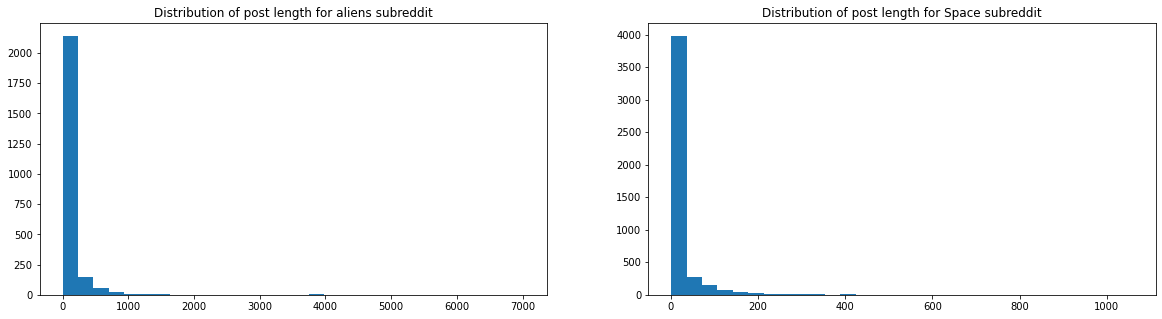

In [30]:
# word count distribution

plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.hist(x = (df[df['aliens'] == 1]['post_length']), bins = 30)
plt.title('Distribution of post length for aliens subreddit')

plt.subplot(1, 2, 2)
plt.hist(x = (df[df['aliens'] == 0]['post_length']), bins = 30)
plt.title('Distribution of post length for Space subreddit')
plt.show();

Visualization of distribution of word length. As mentioned above, the variance of post length of r/aliens is high, thus the heavily right skewed chart. It is the same for r/space. 

In [31]:
df[(df['aliens'] == 1) & (df['post_length'] == 1)]['selftext']

0             NaN
1             NaN
3             NaN
4             NaN
6             NaN
          ...    
2393          NaN
2396          NaN
2397          NaN
2398    [removed]
2399          NaN
Name: selftext, Length: 1215, dtype: object

In [32]:
# selftext for r/space post length == 1

df[(df['aliens'] == 1) & (df['post_length'] == 1)]['selftext'].unique()

array([nan, '[removed]', '[deleted]',
       'https://m.youtube.com/watch?v=hRr4J2ZQbeo&amp;t=1s',
       '[https://www.youtube.com/watch?v=5rZLaiL1m\\_U](https://www.youtube.com/watch?v=5rZLaiL1m_U)',
       '[https://youtu.be/5rZLaiL1m\\_U](https://youtu.be/5rZLaiL1m_U)',
       'https://www.gaia.com/share/ckxngjsvo000i0klc2gs97k5n?rfd=mkPUG2&amp;language[]=en',
       '[https://youtu.be/vSEYv8zWffw](https://youtu.be/vSEYv8zWffw)',
       'Sus', 'Wow.', 'Thoughts?',
       '[https://www.youtube.com/watch?v=OPxfR2zfbk4](https://www.youtube.com/watch?v=OPxfR2zfbk4)',
       'TSA', 'Yup..',
       '[https://www.youtube.com/watch?v=sEczN\\_8Q380&amp;t=762s](https://www.youtube.com/watch?v=sEczN_8Q380&amp;t=762s)',
       '[https://www.youtube.com/watch?v=3aqivLKs2wQ](https://www.youtube.com/watch?v=3aqivLKs2wQ)',
       'Title',
       '[https://www.youtube.com/watch?v=GIx44GSOfHw&amp;ab\\_channel=SHOWTIME](https://www.youtube.com/watch?v=GIx44GSOfHw&amp;ab_channel=SHOWTIME)',
       'ht

In [33]:
df[df['aliens'] == 0]['post_length'].describe()

count    4598.000000
mean       17.118747
std        54.571790
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1059.000000
Name: post_length, dtype: float64

In [34]:
df[(df['aliens'] == 0) & (df['post_length'] > 1000)]['selftext']

3980    Yeah, we get it, Russia, like a bunch of other...
Name: selftext, dtype: object

In [35]:
df[(df['aliens'] == 0) & (df['post_length'] == 1)]['selftext']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
4591    NaN
4592    NaN
4593    NaN
4594    NaN
4596    NaN
Name: selftext, Length: 3648, dtype: object

In [36]:
# selftext for r/aliens post length == 1

df[(df['aliens'] == 0) & (df['post_length'] == 1)]['selftext'].unique()

array([nan,
       '[https://www.youtube.com/watch?v=nl2UQKmZfqc&amp;ab\\_channel=ExoAnalyticSolutionsVideos](https://www.youtube.com/watch?v=nl2UQKmZfqc&amp;ab_channel=ExoAnalyticSolutionsVideos)',
       '[removed]', '\nhttps://youtu.be/YdJZQSr7cyo',
       '[https://www.theguardian.com/science/2022/jan/26/out-of-control-spacex-rocket-on-track-to-collide-with-the-moon](https://www.theguardian.com/science/2022/jan/26/out-of-control-spacex-rocket-on-track-to-collide-with-the-moon)',
       '[https://youtu.be/8G84OP48uK0](https://youtu.be/8G84OP48uK0)',
       '[https://youtu.be/xLzD00ATZ0M](https://youtu.be/xLzD00ATZ0M)',
       '[https://youtu.be/AXACzZFfFfg](https://youtu.be/AXACzZFfFfg)',
       '[deleted]', 'www.jwst.nasa.gov',
       '[https://jwst.nasa.gov/content/webbLaunch/whereIsWebb.html](https://jwst.nasa.gov/content/webbLaunch/whereIsWebb.html)',
       '[https://youtu.be/iEBfkRqqHZE](https://youtu.be/iEBfkRqqHZE)',
       'Title',
       '[https://www.youtube.com/watch?v=g

For post_length == 1, it mostly contains NaN, [removed], [deleted] and links. It is the same for both subreddits. Consider removing these.

In [37]:
# selftext for r/space post length == 2

df[(df['aliens'] == 0) & (df['post_length'] == 2)]['selftext'].unique()

array(['LETSGOO\n\nhttps://preview.redd.it/wikovahidq881.png?width=1291&amp;format=png&amp;auto=webp&amp;s=6c68d5bf92576474eb4a398692135ebda07c0e20',
       'https://phys.org/news/2021-12-galaxies-explore-universe.html\n\nhttps://aladin.u-strasbg.fr/AladinLite/',
       '&amp;#x200B;\n\nhttps://preview.redd.it/rand04dwq3881.jpg?width=1649&amp;format=pjpg&amp;auto=webp&amp;s=8c02bc278252b0152d6556b0360d5d992c8f5ffc',
       '&amp;#x200B;\n\nhttps://preview.redd.it/njlc61mve8581.png?width=1164&amp;format=png&amp;auto=webp&amp;s=d2e31f25a0aaa110b14b7b4b59ca29a9932c44fb',
       '&amp;#x200B;\n\nhttps://preview.redd.it/cgdcpqoj94581.png?width=1168&amp;format=png&amp;auto=webp&amp;s=a68cd2416345ae66a81992fd4ccdebe3025aabf3',
       'Just wondering.',
       '&amp;#x200B;\n\n[https:\\/\\/www.nasa.gov\\/planetarydefense\\/dart\\/](https://preview.redd.it/161b17083g181.jpg?width=297&amp;format=pjpg&amp;auto=webp&amp;s=e2ee54c131b53913f3a353c955817b366c85ea70)',
       'Any videos?',
       '&a

In [38]:
# selftext for r/aliens post length == 2

df[(df['aliens'] == 1) & (df['post_length'] == 2)]['selftext'].unique()

array(['Would you', "IT'S CATS",
       '&amp;#x200B;\n\nhttps://preview.redd.it/ihhlls1ntn281.jpg?width=720&amp;format=pjpg&amp;auto=webp&amp;s=3116b9ee70ee59924dea55a7982df67bc0ad8106',
       'Ur thoughts?',
       '&amp;#x200B;\n\nhttps://preview.redd.it/c43tesff92w71.jpg?width=1423&amp;format=pjpg&amp;auto=webp&amp;s=e5858a492d941746a6add49498767bd18115a50e'],
      dtype=object)

For post length == 2, it is made up of mostly links plus markdown text formatting. Will remove markdown formatting.

In [39]:
# selftext for r/space post length == 3

df[(df['aliens'] == 0) & (df['post_length'] == 3)]['selftext'].unique()

array(['[Where is Webb](https://jwst.nasa.gov/content/webbLaunch/whereIsWebb.html)',
       'For reference:  \n[https://www.reddit.com/r/space/comments/r8omon/china\\_lunar\\_rover\\_to\\_check\\_out\\_cubeshaped\\_mystery/](https://www.reddit.com/r/space/comments/r8omon/china_lunar_rover_to_check_out_cubeshaped_mystery/)',
       'Just curious guys', 'pretty much title.',
       'Edit : https://en.m.wikipedia.org/wiki/Bo%C3%B6tes_void',
       'Would be cool.', 'Isn’t it true?'], dtype=object)

In [40]:
# selftext for r/aliens post length == 3

df[(df['aliens'] == 1) & (df['post_length'] == 3)]['selftext'].unique()

array(['&amp;#x200B;\n\n[Just sayin...](https://i.redd.it/alxf71hrzz781.gif)',
       '?????? your thoughts', 'What could happen?',
       'Here evidence https://scp-wiki.wikidot.com/scp-163',
       'enlil and anu', 'Don’t put opinions.'], dtype=object)

From post length 3 onwards, some posts are beginning to make some sense. Consider removing post length 2 and below.

In [41]:
# NaN count for r/aliens selftext

print(df[df['aliens'] == 1]['selftext'].isna().sum())
print('Percentage of NaN for r/aliens: ',(df[df['aliens'] == 1]['selftext'].isna().sum())/(df['aliens'] == 1).sum())

1009
Percentage of NaN for r/aliens:  0.42041666666666666


In [42]:
# NaN count for r/space selftext

print(df[df['aliens'] == 0]['selftext'].isna().sum())
print('Percentage of NaN for r/space: ',(df[df['aliens'] == 0]['selftext'].isna().sum())/(df['aliens'] == 0).sum())

3364
Percentage of NaN for r/space:  0.7316224445411048


In [43]:
# Number of posts after removing NaN for both

print('Number of Non NaN posts for Aliens: ',df[df['aliens'] == 1]['selftext'].notna().sum())
print('Number of Non NaN posts for Space: ',df[df['aliens'] == 0]['selftext'].notna().sum())

Number of Non NaN posts for Aliens:  1391
Number of Non NaN posts for Space:  1234


After removing NaN from selftext, sample size from both reddits are about the same. Dropping NaN will be beneficial in this case.

#### Non English Characters

In [44]:
# counting number of non ascii char in df

not_english_char_list = []
df_temp = df[df['selftext'].notnull()] # remove nan temporarily

for item in df_temp['selftext']: # adds char to not_english_char_list if not in ascii
    for char in item:
        if char.isascii() == False:
            not_english_char_list.append(char)
            
not_english_char_list_2 = [] # adds char to not_english_char_list_2 if not in ascii
for item in df_temp['title']:
    for char in item:
        if char.isascii() == False:
            not_english_char_list.append(char)
            
print('selftext non english char length: ',len(not_english_char_list))
print('title non english char length: ',len(not_english_char_list_2))

selftext non english char length:  15552
title non english char length:  0


Length of non english char list is 15539 for selftext. check downstream after further cleaning to see if removed.

### 7. Cleaning

#### Remove all null values from selftext

In [45]:
# remove all NaN from selftext

df = df[df['selftext'].notna()]

#### Remove [removed] and [deleted]


In [46]:
# counting number of removed and deleted

(df['selftext'] == '[removed]').sum() + (df['selftext'] == '[deleted]').sum()

419

In [47]:
print(df.shape[0]) # current total rows
print(len(df[df['aliens'] == 0])) # total rows for space
print(len(df[df['aliens'] == 1])) # total rows for aliens


2625
1234
1391


In [48]:
# replace removed and deleted with nan

df['selftext'].replace(to_replace = ['[deleted]', '[removed]'], value=np.nan, inplace = True)

In [49]:
# remove all null values from selftext

df = df[df['selftext'].notna()]

In [50]:
# counting number of removed and deleted

(df['selftext'] == '[removed]').sum() + (df['selftext'] == '[deleted]').sum()

0

In [51]:
# current total rows

df.shape[0]

2206

#### Lowercase posts and titles for further processing

In [52]:
df['selftext'] = df['selftext'].apply(lambda x: x.lower())
df['title'] = df['title'].apply(lambda x: x.lower())

#### Remove links from posts

In [53]:
# checking for links in selftext

for item in df['selftext']:
    if 'http' in item:
        print(item)

[https://www.youtube.com/watch?v=nl2uqkmzfqc&amp;ab\_channel=exoanalyticsolutionsvideos](https://www.youtube.com/watch?v=nl2uqkmzfqc&amp;ab_channel=exoanalyticsolutionsvideos)
hello!  
i am working on rocket crew ( space job board ) and i would like to start a series of interviews about people working in the space industry.

the goal is to help people interested in space understand what it is like working in this industry (daily tasks, what you are working on right now, etc)

if you would like to share your experience, you can dm me on reddit, or contact me on [twitter](https://twitter.com/rocketcrewspace)

thanks!
story here in russian.

[https://ria.ru/20220125/angara-1769448485.html](https://ria.ru/20220125/angara-1769448485.html)

english precis here (social media)  

[**katya pavlushchenko**](https://twitter.com/katlinegrey)

[**https://twitter.com/katlinegrey/status/1486224903011553288**](https://twitter.com/katlinegrey/status/1486224903011553288)

&gt; 1/2. roscosmos considers a

In [54]:
# remove links

df['selftext'] = df['selftext'].apply(lambda x: re.sub(r'http\S+', '', x))

In [55]:
# checking for links in selftext

for item in df['selftext']:
    if 'http' in item:
        print(item)

In [56]:
# checking for links in title

for item in df['title']:
    if 'http' in item:
        print(item)

https://www.youtube.com/watch?v=_m4psfdagus&amp;t=80s
https://www.vice.com/en/article/ep4dan/ufo-subreddit-was-subject-to-systemic-censorship "become a moderator" pretty sure the mods here are censoring like r/ufos were...


In [57]:
# remove links

df['title'] = df['title'].apply(lambda x: re.sub(r'http\S+', '', x))

In [58]:
# checking for links in title

for item in df['title']:
    if 'http' in item:
        print(item)

#### Remove Emojis

In [59]:
# check post_length == 1 content after removing above

df['selftext'][df['post_length'] == 1].unique()

array(['[', '\n', 'www.jwst.nasa.gov', 'title', '🥲', ' [',
       '[presentation](', '[video](', '[here](', '[moteofdust.org](', '',
       'sus', 'wow.', 'thoughts?', 'tsa', 'yup..', '.', 'aloem', 'h', '?'],
      dtype=object)

In [60]:
# remove emoji

df['selftext'] = df['selftext'].apply(lambda x: remove_emoji(x))

In [61]:
# check that emoji removed

df['selftext'][df['post_length'] == 1].unique()

array(['[', '\n', 'www.jwst.nasa.gov', 'title', '', ' [',
       '[presentation](', '[video](', '[here](', '[moteofdust.org](',
       'sus', 'wow.', 'thoughts?', 'tsa', 'yup..', '.', 'aloem', 'h', '?'],
      dtype=object)

In [62]:
# remove emoji from title, assuming their existence

df['title'] = df['title'].apply(lambda x: remove_emoji(x)) 

#### Remove markdown text formatting

In [63]:
df['selftext'] = df['selftext'].apply(lambda x: redditcleaner.clean(x))
df['title'] = df['title'].apply(lambda x: redditcleaner.clean(x))

In [64]:
df['selftext']

8                                                       [
18      i‘ve been asking myself that for quite some ti...
26      whenever youtube channels talk about space/ as...
28      in which general cardinal direction will a lau...
34      hi everyone, spaceblue is a community token th...
                              ...                        
2383    [an interview with travis walton: the man abdu...
2385    this book has no author and is about the origi...
2389    in the past prior to my extraterrestrial ufo/u...
2394                                          &amp;x200b;
2395    tr3b patent (triangular spacecraft, its right ...
Name: selftext, Length: 2206, dtype: object

In [65]:
df['title']

8       there is some interesting things going on in o...
18              how would actual space warfare look like?
26                             orbital mineral refineries
28                                         sso trajectory
34                      free 88 million of spacebluetoken
                              ...                        
2383    travis walton full lenh interview - alien abdu...
2385                        need help looking for a book.
2389    thoughts about the future of global wealth res...
2394          full underwater baltic ufo crash screenshot
2395                haarp and tr3b patents-uap explained?
Name: title, Length: 2206, dtype: object

#### Remove Non eng char

In [66]:
english_check(df['selftext'])

i‘ve been asking myself that for quite some time now. when i say space warfare, i’m refering to multiple parties separated by space, like two planetary colonies fighting. obviously it would be a very slow and long ranged endeavor. i have multiple scenarios i’d like your opinion on. 1. interplanetary warfare. i think this is probably the easiest, but also most destructive way to fight. just launch a rod of metal at another planet fast enough and you have essentially a nuke. how could you be able to protect yourself from this kind of thing? perhaps something like a missile defense system? idk i‘d like your opinions on that. 2. fighting in space assuming you managed to protect yourself from just plain missiles or you actually plan to send down a land invasion force, you would probably have to engage in space. i imagine something similar to submarines fighting, with additional predicaments like heat management. also how would you track an enemy spaceship and how would you try to hide yours

In [67]:
df['selftext'] = df['selftext'].apply(lambda x: return_eng_char(x))

In [68]:
english_check(df['selftext'])

In [69]:
english_check(df['title'])

why isn’t every star not inside a galaxy


In [70]:
df['title'] = df['title'].apply(lambda x: return_eng_char(x))

In [71]:
english_check(df['title'])

#### Tokenize text by splitting, remove stopwords and lemmatize.

The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

However, the two words differ in their flavor. Stemming usually chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. Lemmatization shortens words with the use of a vocabulary and morphological analysis of words, normally aiming to return the base or dictionary form of a word, which is known as the lemma. Thus, we will lemmatize words.

In [72]:
#get the stopwords
stopwords = stopwords.words('english')

In [73]:
df['selftext'] = df['selftext'].apply(lambda x: process_text(x))
df['title'] = df['title'].apply(lambda x: process_text(x))

In [74]:
df.head()

,title,selftext,aliens,post_length,title_length
8,interesting thing going orbit today,,0,1,10
18,would actual space warfare look like,asking quite time say space warfare refering m...,0,210,7
26,orbital mineral refinery,whenever youtube channel talk space asteroid m...,0,47,3
28,sso trajectory,general cardinal direction launch vehicle cape...,0,18,2
34,free million spacebluetoken,hi everyone spaceblue community token support ...,0,92,5


In [75]:
english_check(df['selftext'])

#### Removing outliers

In [76]:
# reset post_length

df['post_length'] = df['selftext'].map(lambda x: len(str(x).split()))

In [77]:
df[df['aliens'] == 1].describe()

,aliens,post_length,title_length
count,1222.0,1222.000000,1222.000000
mean,1.0,88.563011,10.850245
std,0.0,185.929748,8.677760
min,1.0,0.000000,1.000000
25%,1.0,17.000000,5.000000
50%,1.0,41.000000,8.000000
75%,1.0,92.000000,14.000000
max,1.0,2855.000000,57.000000


In [78]:
df[df['aliens'] == 1].describe([0.03, 0.25,0.50,0.75,0.8,0.9,0.99])

,aliens,post_length,title_length
count,1222.0,1222.000000,1222.000000
mean,1.0,88.563011,10.850245
std,0.0,185.929748,8.677760
min,1.0,0.000000,1.000000
3%,1.0,1.000000,2.000000
25%,1.0,17.000000,5.000000
50%,1.0,41.000000,8.000000
75%,1.0,92.000000,14.000000
80%,1.0,115.000000,15.800000
90%,1.0,193.900000,22.000000


remove all posts with post_length 1 and below, to cut out some posts that do not provide any useful information for our model. also remove extremely long post.

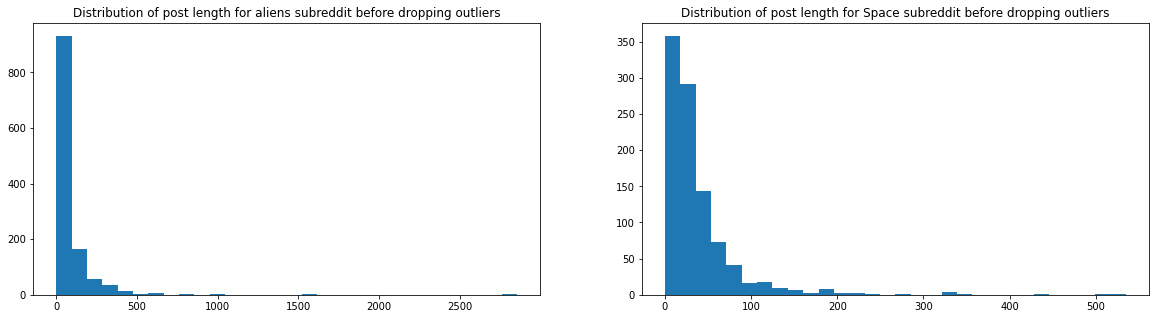

In [79]:
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.hist(x = (df[df['aliens'] == 1]['post_length']), bins = 30)
plt.title('Distribution of post length for aliens subreddit before dropping outliers')

plt.subplot(1, 2, 2)
plt.hist(x = (df[df['aliens'] == 0]['post_length']), bins = 30)
plt.title('Distribution of post length for Space subreddit before dropping outliers')
plt.show();

In [80]:
df_1 = df[df['post_length'] < 194] # remove post length above the 90 percentile
df_2 = df_1[df_1['post_length'] > 2] # remove post length below 2
df = df_2

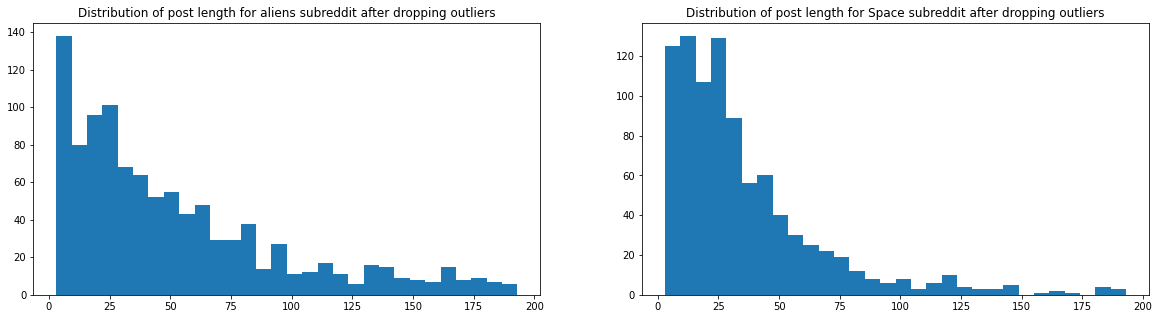

In [81]:
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.hist(x = (df[df['aliens'] == 1]['post_length']), bins = 30)
plt.title('Distribution of post length for aliens subreddit after dropping outliers')

plt.subplot(1, 2, 2)
plt.hist(x = (df[df['aliens'] == 0]['post_length']), bins = 30)
plt.title('Distribution of post length for Space subreddit after dropping outliers')
plt.show();

#### Combine selftext and title

Combine selftext with title to avoid losing valuable information available in the title.

In [82]:
df['combined'] = df['selftext'] + df['title']

In [83]:
df['combined']

18      asking quite time say space warfare refering m...
26      whenever youtube channel talk space asteroid m...
28      general cardinal direction launch vehicle cape...
34      hi everyone spaceblue community token support ...
36      yeah know fusion always year away people iter ...
                              ...                        
2380    see post talking alien god created universe lo...
2383    interview travis walton man abducted alien con...
2385    book author origin life believe three part boo...
2394    amp x bfull underwater baltic ufo crash screen...
2395    tr b patent triangular spacecraft right f ing ...
Name: combined, Length: 1950, dtype: object

###### Top words from each subreddit

In [84]:
from nltk.corpus import stopwords
# extending stop words
stopwords = stopwords.words('english')
stopwords.extend(['like', 'just', 'would', 'could', 'know'])

911


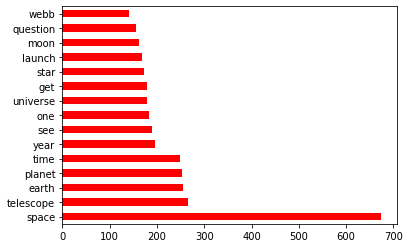

In [85]:
# counting most appeared words for space
cv = CountVectorizer(stop_words = stopwords, min_df = 3, ngram_range = (1,1))
cv.fit(df[df['aliens'] == 0]['combined']) # aliens == 0 for space subreddit
space_cv = cv.transform(df[df['aliens'] == 0]['combined'])
space_cvec_df = pd.DataFrame(space_cv.todense(), columns=cv.get_feature_names_out())
print(len(space_cvec_df))
space_cvec_df.sum().sort_values(ascending=False).head(15).plot(kind="barh", color = 'red');

# saved for later use
space_important_features = space_cvec_df.sum().sort_values(ascending=False).head(15) 



1039


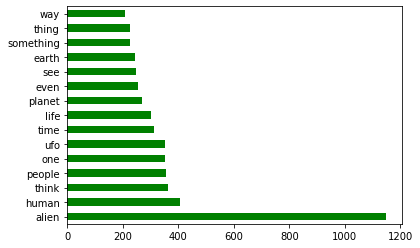

In [86]:
# counting most appeared words for alien

cv = CountVectorizer(stop_words=stopwords, min_df=3, ngram_range=(1,1))
cv.fit(df[df['aliens'] == 1]['combined']) # aliens == 1 for alien subreddit

alien_cv = cv.transform(df[df['aliens'] == 1]['combined'])
alien_cvec_df = pd.DataFrame(alien_cv.todense(), columns=cv.get_feature_names())
print(len(alien_cvec_df))
alien_cvec_df.sum().sort_values(ascending=False).head(15).plot(kind="barh", color = 'green');

# saved for later use
alien_important_features = alien_cvec_df.sum().sort_values(ascending=False).head(15)

911


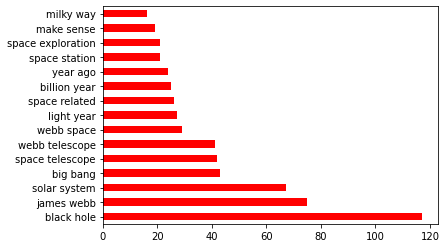

In [87]:
# most common bigrams for space

cv = CountVectorizer(stop_words = stopwords, min_df = 3, ngram_range = (2,2))
cv.fit(df[df['aliens'] == 0]['combined']) # aliens == 0 for space subreddit
space_cv = cv.transform(df[df['aliens'] == 0]['combined'])
space_cvec_df = pd.DataFrame(space_cv.todense(), columns=cv.get_feature_names_out())
print(len(space_cvec_df))
space_cvec_df.sum().sort_values(ascending=False).head(15).plot(kind="barh", color = 'red');

# saved for later use
space_important_features = space_cvec_df.sum().sort_values(ascending=False).head(15) 

1039


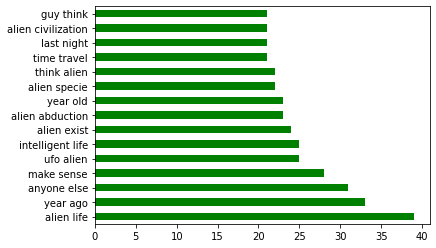

In [88]:
# counting most bigrams for alien

cv = CountVectorizer(stop_words=stopwords, min_df=3, ngram_range=(2,2))
cv.fit(df[df['aliens'] == 1]['combined']) # aliens == 1 for alien subreddit

alien_cv = cv.transform(df[df['aliens'] == 1]['combined'])
alien_cvec_df = pd.DataFrame(alien_cv.todense(), columns=cv.get_feature_names())
print(len(alien_cvec_df))
alien_cvec_df.sum().sort_values(ascending=False).head(15).plot(kind="barh", color = 'green');

# saved for later use
alien_important_features = alien_cvec_df.sum().sort_values(ascending=False).head(15)

In [89]:
alien_cvec_df

,abducted alien,abduction case,abduction experience,abduction phenomenon,abduction story,able communicate,able find,able live,able see,account people,...,year alien,year earth,year get,year huge,year later,year old,year think,youtube channel,youtube video,zeta reticuli
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1035,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Top 5 common words from space subreddit are: <br>
- space
- earth
- telescope
- planet
- time
<br><br>
Top 5 common words from aliens subreddit are:<br><br>
- alien
- human
- one
- people
- think

These are the top 5 words that appear most commonly in each of the subreddits. Among them, we can see that both unigrams and bigrams for both subreddits are quite different. This could indicate that the subreddits could be classified effectively. 

### 8. Modeling

In [90]:
X = df['combined']
y = df['aliens']

In [91]:
X.shape

(1950,)

In [92]:
y.shape

(1950,)

#### Baseline score

In [93]:
y.value_counts(normalize = True)

1    0.532821
0    0.467179
Name: aliens, dtype: float64

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [95]:
# Pipeline & Gridsearch setup

# TFIDF pipeline setup
# mb
tfidf_mb_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('mb', MultinomialNB())
])
# Randomforest
tfidf_rf_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('rf', RandomForestClassifier())
])
# logistic regression
tfidf_lr_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])


# CVec pipeline setup
# mb
cvec_mb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mb', MultinomialNB())
])
# random forest
cvec_rf_pipe = Pipeline([
 ('cvec', CountVectorizer()),
 ('rf', RandomForestClassifier())
])
# logistic regression
cvec_lr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])


# Setting params for TFIDF Vectorizer gridsearch
tf_params = {
#  'tvec__max_features':[100, 2000, 3000 ,4000],
#  'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
#  'tvec__stop_words': [None, 'english'],   
}

# setting up cvec params
cvec_params = {
#  'cvec__max_features':[100, 2000, 3000, 4000],
#  'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
#  'cvec__stop_words': [None, 'english'],
}

In [96]:
# Setting up GridSearch for tfidf
tfidf_mb_gs = GridSearchCV(tfidf_mb_pipe, param_grid=tf_params, cv = 5, verbose =1, n_jobs = -1)
tfidf_rf_gs = GridSearchCV(tfidf_rf_pipe, param_grid=tf_params, cv = 5, verbose =1, n_jobs = -1)
tfidf_lr_gs = GridSearchCV(tfidf_lr_pipe, param_grid=tf_params, cv = 5, verbose = 1, n_jobs = -1)
# tfidf_cat_gs = GridSearchCV(tfidf_cat_pipe, param_grid=tf_params, cv = 5, verbose = 1, n_jobs = -1)


In [97]:
# Setting up GridSearch for cvec
cvec_mb_gs = GridSearchCV(cvec_mb_pipe, param_grid=cvec_params, cv = 5, verbose =1, n_jobs = -1)
cvec_rf_gs = GridSearchCV(cvec_rf_pipe, param_grid=cvec_params, cv = 5, verbose =1, n_jobs = -1)
cvec_lr_gs = GridSearchCV(cvec_lr_pipe, param_grid=cvec_params, cv = 5, verbose =1, n_jobs = -1)
# cvec_cat_gs = GridSearchCV(cvec_cat_pipe, param_grid=cvec_params, cv = 5, verbose =1, n_jobs = -1)

In [98]:
# remember to uncomment when running

tfidf_mb_gs.fit(X_train, y_train)
tfidf_rf_gs.fit(X_train, y_train)
tfidf_lr_gs.fit(X_train, y_train)
# tfidf_cat_gs.fit(X_train, y_train)
cvec_mb_gs.fit(X_train, y_train)
cvec_rf_gs.fit(X_train, y_train)
cvec_lr_gs.fit(X_train, y_train)
# cvec_cat_gs.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1, param_grid={}, verbose=1)

In [99]:
print('Baseline Scores:')
print('-')
print('TFIDF scores:')
print('-----------------')
print('tfidf_mb_gs training set score: ',tfidf_mb_gs.score(X_train, y_train))
print('tfidf_mb_gs testing set score: ',tfidf_mb_gs.score(X_test, y_test))
print('spread = ',tfidf_mb_gs.score(X_train, y_train) - tfidf_mb_gs.score(X_test, y_test))
print('-')
print('tfidf_rf_gs training set score: ',tfidf_rf_gs.score(X_train, y_train))
print('tfidf_rf_gs testing set score: ',tfidf_rf_gs.score(X_test, y_test))
print('spread = ',tfidf_rf_gs.score(X_train, y_train) - tfidf_rf_gs.score(X_test, y_test))
print('-')
print('tfidf_lr_gs training set score: ',tfidf_lr_gs.score(X_train, y_train))
print('tfidf_lr_gs testing set score: ',tfidf_lr_gs.score(X_test, y_test))
print('spread = ',tfidf_lr_gs.score(X_train, y_train) - tfidf_lr_gs.score(X_test, y_test))
print('-')
# print('tfidf_cat_gs training set score: ',tfidf_cat_gs.score(X_train, y_train))
# print('tfidf_cat_gs testing set score: ',tfidf_cat_gs.score(X_test, y_test))
# print('spread = ',tfidf_cat_gs.score(X_train, y_train) - tfidf_cat_gs.score(X_test, y_test))
# print('-')
print(' ')
print('CVec scores: ')
print('-----------------')
print('cvec_mb_gs training set score: ',cvec_mb_gs.score(X_train, y_train))
print('cvec_mb_gs testing set score: ',cvec_mb_gs.score(X_test, y_test))
print('spread = ',cvec_mb_gs.score(X_train, y_train) - cvec_mb_gs.score(X_test, y_test))
print('-')
print('cvec_rf_gs training set score: ',cvec_rf_gs.score(X_train, y_train))
print('cvec_rf_gs testing set score: ',cvec_rf_gs.score(X_test, y_test))
print('spread = ',cvec_rf_gs.score(X_train, y_train) - cvec_rf_gs.score(X_test, y_test))
print('-')
print('cvec_lr_gs training set score: ',cvec_lr_gs.score(X_train, y_train))
print('cvec_lr_gs testing set score: ',cvec_lr_gs.score(X_test, y_test))
print('spread = ',cvec_lr_gs.score(X_train, y_train) - cvec_lr_gs.score(X_test, y_test))
print('-')
# print('cvec_cat_gs training set score: ',cvec_cat_gs.score(X_train, y_train))
# print('cvec_cat_gs testing set score: ',cvec_cat_gs.score(X_test, y_test))
# print('spread = ',cvec_cat_gs.score(X_train, y_train) - cvec_cat_gs.score(X_test, y_test))
print('-')

Baseline Scores:
-
TFIDF scores:
-----------------
tfidf_mb_gs training set score:  0.96922024623803
tfidf_mb_gs testing set score:  0.889344262295082
spread =  0.07987598394294804
-
tfidf_rf_gs training set score:  1.0
tfidf_rf_gs testing set score:  0.8995901639344263
spread =  0.10040983606557374
-
tfidf_lr_gs training set score:  0.9726402188782489
tfidf_lr_gs testing set score:  0.9118852459016393
spread =  0.06075497297660959
-
 
CVec scores: 
-----------------
cvec_mb_gs training set score:  0.9740082079343365
cvec_mb_gs testing set score:  0.9077868852459017
spread =  0.06622132268843484
-
cvec_rf_gs training set score:  1.0
cvec_rf_gs testing set score:  0.889344262295082
spread =  0.11065573770491799
-
cvec_lr_gs training set score:  0.9993160054719562
cvec_lr_gs testing set score:  0.8790983606557377
spread =  0.12021764481621855
-
-


Baseline score for models. From the results, we can see that all of the models are able to predict y with a decent amount of accuracy.<br><br>
Best performing models: tfidf_lr, cvec_mb, tfidf_mb

#### Count and Tfidf Vectorizer

TfidfVectorizer and CountVectorizer both are methods for converting text data into vectors as model can process only numerical data.

In CountVectorizer we only count the number of times a word appears in the document which results in biasing in favour of most frequent words. this ends up in ignoring rare words which could have helped is in processing our data more efficiently.

To overcome this , we use TfidfVectorizer .

In TfidfVectorizer we consider overall document weightage of a word. It helps us in dealing with most frequent words. Using it we can penalize them. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.

#### Multinomial Naive Bayes

The Naive Bayes classifier separates data into different classes according to the Bayes’ Theorem, along with the assumption that all the predictors are independent of one another. It assumes that a particular feature in a class is not related to the presence of other features. <br><br>
This algorithm can even outperform highly advanced classification techniques, it is simple and can be built quickly.<br><br>
However, it assumes that all features are independent, which may not be true in our case.

In [100]:
# gs for best mb params

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mb', MultinomialNB())
])
params = {
 'tvec__max_features':[100, 2000, 3000 ,4000],
 'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
 'tvec__stop_words': [None, 'english'], 
    'mb__alpha': [1, 2, 3, 4]
    
}
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'mb__alpha': [1, 2, 3, 4],
                         'tvec__max_features': [100, 2000, 3000, 4000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [101]:
gs.best_params_

{'mb__alpha': 1,
 'tvec__max_features': 4000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [102]:
# fitting optimal tfidf mb

tvec = TfidfVectorizer(max_features = 2000, ngram_range = (1,2), stop_words = 'english')
X_train_tvec_mb = tvec.fit_transform(X_train)
X_test_tvec_mb = tvec.transform(X_test)
tvec_mb = MultinomialNB(alpha = 1)
tvec_mb.fit(X_train_tvec_mb, y_train)

MultinomialNB(alpha=1)

In [103]:
# declare df_score

df_score = pd.DataFrame(columns = ['Vectorizer', 'Classifier', 'Train Score', 'Test Score', 'Spread', 'Precision', 'Recall', 'Accuracy', 'F1'])

In [104]:
# add model scores to df_score

add_score(tvec, tvec_mb, X_train_tvec_mb, X_test_tvec_mb, y_train, y_test)

#### Count Vectorizer with Multinomial NB Classifier

In [105]:
# gridsearch best cvec and mb params

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mb', MultinomialNB())
])
params = {
 'cvec__max_features':[100, 2000, 3000, 4000],
 'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
 'cvec__stop_words': [None, 'english'],
    'cvec__max_df': [.5, .75, 85],
    'cvec__min_df': [2, 4, 6],
    'mb__alpha': [1, 2, 3, 4]
}
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.5, 0.75, 85],
                         'cvec__max_features': [100, 2000, 3000, 4000],
                         'cvec__min_df': [2, 4, 6],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'mb__alpha': [1, 2, 3, 4]})

In [106]:
# best params for mb

gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'mb__alpha': 1}

In [107]:
# fitting optimal cvec mb

cvec = CountVectorizer(stop_words='english', ngram_range=(
    1, 2), max_df=0.5, min_df=2, max_features=4000)

X_train_cvec_mb = cvec.fit_transform(X_train)

X_test_cvec_mb = cvec.transform(X_test)

cvec_mb = MultinomialNB(alpha = 3)

cvec_mb.fit(X_train_cvec_mb, y_train)


MultinomialNB(alpha=3)

In [108]:
# add model scores to df_score

add_score(cvec, cvec_mb, X_train_cvec_mb, X_test_cvec_mb, y_train, y_test)

#### Tfidf Vectorizer with Logistic Regression

Logistic regression is a classification algorithm used to find the probability of event success and event failure. It is used when the dependent variable is binary(0/1, True/False, Yes/No, in our case Space/Alien) in nature. It supports categorizing data into discrete classes by studying the relationship from a given set of labelled data. It learns a linear relationship from the given dataset and then introduces a non-linearity in the form of the Sigmoid function.<br><br>
It is quick and easy to implement, and model coefficients can be indicators of feature importance.<br><br>
However, similarly to Multinomial Naive Bayes, it requires average or no multicollinearity between independent variables.

In [109]:
# gs for best lr params

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])
params = {
 'tvec__max_features':[100, 2000, 3000 ,4000],
 'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
 'tvec__stop_words': [None, 'english'], 
    'lr__solver': ['liblinear'],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1, .8, .6]
    
#     'lr__alpha': [1, 2, 3, 4]
    
}
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': [1, 0.8, 0.6], 'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['liblinear'],
                         'tvec__max_features': [100, 2000, 3000, 4000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [110]:
gs.best_params_

{'lr__C': 1,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear',
 'tvec__max_features': 4000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None}

In [111]:
# fitting optimal tfidf lr

tvec = TfidfVectorizer(max_features = 2000, ngram_range = (1,1), stop_words = None)
X_train_tvec_lr = tvec.fit_transform(X_train)
X_test_tvec_lr = tvec.transform(X_test)

tvec_lr = LogisticRegression(solver='liblinear', penalty = 'l2', C=1)

tvec_lr.fit(X_train_tvec_lr, y_train)

LogisticRegression(C=1, solver='liblinear')

In [112]:
# add model scores to df_score

add_score(tvec, tvec_lr, X_train_tvec_lr, X_test_tvec_lr, y_train, y_test)

### 9. Scoring Models

In [113]:
df_score

,Vectorizer,Classifier,Train Score,Test Score,Spread,Precision,Recall,Accuracy,F1
0,TfidfVectorizer,MultinomialNB,0.939124,0.895492,0.043633,0.880000,0.930769,0.895492,0.904673
1,CountVectorizer,MultinomialNB,0.946648,0.915984,0.030665,0.904059,0.942308,0.915984,0.922787
2,TfidfVectorizer,LogisticRegression,0.958276,0.909836,0.048440,0.909091,0.923077,0.909836,0.916031


The top 3 scoring models show a very close accuracy and f1 score. <br><br>

Accuracy is the ratio of correctly predicted observations to the total observations.<br><br>

F1 score is the harmonic mean between precision and recall.<br><br>

We are interested in being able to accurately classify posts from aliens to space. A score with low False Negatives and False Positives is ideal. Thus, we want a good F1 score.<br><br>
A
ll 3 models are able to classify the posts accurately 88% to 90% of the time, with Multinomial MB with Count Vectorizer being the most accurate.

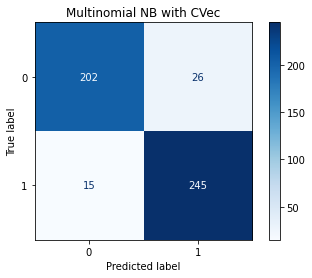

In [114]:
ConfusionMatrixDisplay.from_predictions(y_test, cvec_mb.predict(X_test_cvec_mb), cmap='Blues')
plt.title('Multinomial NB with CVec');

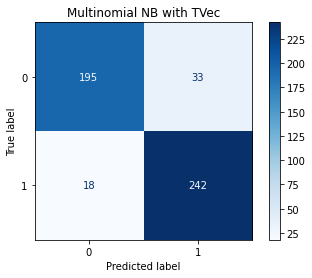

In [115]:
ConfusionMatrixDisplay.from_predictions(y_test, tvec_mb.predict(X_test_tvec_mb), cmap='Blues')
plt.title('Multinomial NB with TVec');

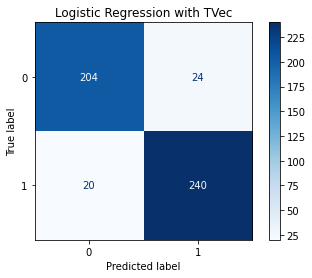

In [116]:
ConfusionMatrixDisplay.from_predictions(y_test, tvec_lr.predict(X_test_tvec_lr), cmap='Blues')
plt.title('Logistic Regression with TVec');

The confusion matrices show the number of False Positives and False Negatives that were predicted by our models. They are the 2 numbers we want to decrease in order to improve accuracy. <br><br>

From the matrices, we can see that the model with the highest FP/FN is Multinomial NB with Tfidf Vectorizer. It is also more likely to predict a FN as compared to the other models.<br><br>

The model with the least False Positives + False Negatives is Logistic Regression with Tfidf Vectorizer

#### AUC Curve

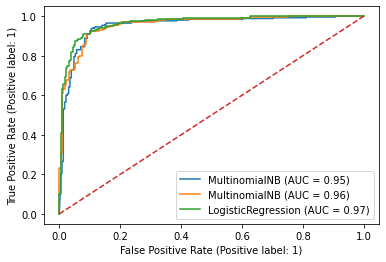

In [117]:
cvec_mb_disp = plot_roc_curve(cvec_mb, X_test_cvec_mb, y_test)
tvec_mb_disp = plot_roc_curve(tvec_mb, X_test_tvec_mb, y_test, ax = cvec_mb_disp.ax_)
tvec_lr_disp = plot_roc_curve(tvec_lr, X_test_tvec_lr, y_test, ax = tvec_mb_disp.ax_)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--') # to simulate random guess 
plt.show();

The baseline reference line is depicted to portray how good/bad our model is. If the FPR = TPR then the model curve (blue line) will lie exactly on the orange line. Signalling an equivalent FP:TP ratio. We want a model that minimizes the FPs and FNs so we can maximize with more TPs and TNs. <br><br>
All 3 models performed similarly, with Logistic Regression with Tfidf Vectorizer inching ahead.

### 10. Choice of Production Model: Logistic Regression with Tfidf Vectorizer.

All 3 of the best performing models among a total of 6 models performed fairly well against each other, with accuracy scores of 88% to 90%, recall score of 92% to 95% and precision score of 85% to 89%. 
<br><br>
The F1 scores, which conveys the balance between precision and recall, are also similar ranging from 90% to 91%.
<br><br>
The AUC scores range from 96% to 97%.
<br><br>
As stated by the above scores, all 3 models will be able to predict whether a post is from space or aliens very well. Given a post, they are able to classify it to the correct subreddit about 90% of the time.<br><br>

We chose Logistic Regression with Tfidf Vectorizer to put into production as it is the simplest and the least 'blackbox' of the models. <br><br>
Although Logistic Regression does not handle non linear features well, it did good in our case.

#### Feature Importance in chosen model, Logistric Regression with Tfidf Vectorizer

In [118]:
coefs = tvec_lr.coef_.flatten()

In [119]:
feature_names = tvec.get_feature_names_out()

In [120]:
zipped = zip(feature_names, coefs)

In [121]:
feature_importance = pd.DataFrame(zipped, columns = ['feature', 'coefficients'])

In [122]:
feature_importance['odds'] = feature_importance['coefficients'].apply(lambda x: np.exp(x))

In [123]:
# feature importance for alien

feature_importance.sort_values(by = 'odds', ascending = False).head()

,feature,coefficients,odds
44,alien,6.559925,706.218599
1855,ufo,3.217823,24.973683
1661,specie,2.294268,9.917170
841,human,1.964850,7.133841
481,disclosure,1.512307,4.537185


For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times as large as the odds that the observation is not in (y class) when all other variables are held constant.

In [124]:
# feature importance for space

feature_importance.sort_values(by = 'odds', ascending = True)

,feature,coefficients,odds
1653,space,-4.560092,0.010461
1768,telescope,-2.657721,0.070108
972,launch,-2.384058,0.092176
1131,moon,-2.297339,0.100526
938,jwst,-1.787893,0.167312
...,...,...,...
481,disclosure,1.512307,4.537185
841,human,1.964850,7.133841
1661,specie,2.294268,9.917170
1855,ufo,3.217823,24.973683


In [126]:
# Sort the features by the absolute value of their coefficient
feature_importance["abs_value"] = feature_importance["coefficients"].apply(lambda x: abs(x))
feature_importance["colors"] = feature_importance["coefficients"].apply(lambda x: "green" if x > 0 else "red")
feature_importance = feature_importance.sort_values("abs_value", ascending=False)

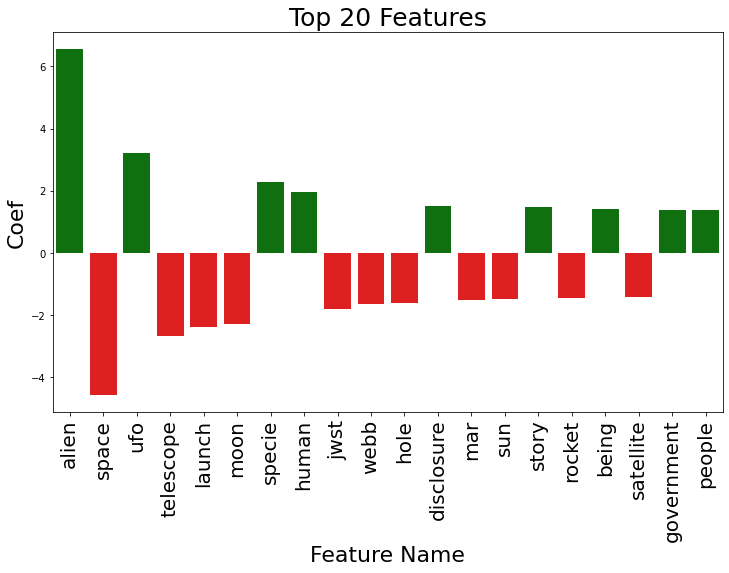

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="coefficients",
            data=feature_importance.head(20),
           palette=feature_importance.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22);

Looking at the Feature Importance, we can see that the Logistic Regression model classifies the post using the feature importance of each word. <br><br>

Space posts on the other hand, contain space, telescope, launch, jwst ( James Webb Space Telescope ), moon, sun, etc. These words are words that represent more factual topics, like the recent launch of the James Webb Space Telescope into space. <br><br>

Aliens posts contain words like aliens, ufo, specie(s), human, extraterrestrial etc. These words could be used in a context where the author is bringing up things like aliens in ufos, different types of alien species, etc.<br><br>

With these features, we will be able to do target marketing. By including these words in the advertisements, or using these words as headlines for articles, 

#### Falsely Predicted Text

In [128]:
y_pred_doublecheck = tvec_lr.predict(X_test_tvec_lr)

In [129]:
df_doublecheck = pd.DataFrame()

In [130]:
df_doublecheck['X_test'] = X_test

In [131]:
df_doublecheck['y_test'] = y_test

In [132]:
df_doublecheck['y_pred_doublecheck'] = y_pred_doublecheck

In [133]:
df_doublecheck.reset_index(drop = True, inplace = True)

In [134]:
# Falsely predicted text

df_doublecheck

,X_test,y_test,y_pred_doublecheck
0,know much space astrophysics however think saf...,0,0
1,scientist look planet say planet life somehow ...,0,0
2,orcus possible dwarf planetlong flyby earth or...,0,0
3,wright patterson airforce base hangar crashed ...,1,1
4,know planet pas front star use discover exopla...,0,0
...,...,...,...
483,sun explodes see exploded minute second explod...,0,0
484,kid dreaming space exploring thinking space th...,0,0
485,advanced could completely aquatic specie becom...,1,1
486,hi mulling astronomy themed dissertation end c...,0,0


In [135]:
df_doublecheck[df_doublecheck['y_test'] != df_doublecheck['y_pred_doublecheck']]

,X_test,y_test,y_pred_doublecheck
12,dr sonny white famous infamous sensational cla...,0,1
14,admit really interested area uaps always looki...,1,0
32,day far everything worked according plan harde...,1,0
41,unless already many reddit page contactees ext...,1,0
58,adult ready heavy stuff secret space program l...,1,0
59,dna carry genetic information body us make pro...,1,0
88,sure right place ask never seen anything like ...,0,1
96,might bit far fetched hear gamma ray burst see...,0,1
99,reference always pondered universe since littl...,0,1
106,lot discussion alien would aggressive peaceful...,0,1


In [136]:
# total number of False results
len(df_doublecheck[df_doublecheck['y_test'] != df_doublecheck['y_pred_doublecheck']])

44

In [144]:
print(df_doublecheck.loc[88,'X_test'])

df_doublecheck.loc[88][1:]

# wrongly predicted class 1, False Negative

sure right place ask never seen anything like pm night last summer taking dog walk saw amber circle high sky size pea held sky near well north shore mountain east vancouver facing northbound across burrard inlet made line inch amber colour left stayed second vanished clue whether military experiment eye failing early probablythink saw unidentified object north shore mountain vancouver bc last summer


y_test                 0
y_pred_doublecheck     1
post_length           63
Name: 88, dtype: object

Ambiguous text with little words with strong coefficients

In [147]:
print(df_doublecheck.loc[358,'X_test'])

df_doublecheck.loc[358][1:]

# wrongly predicted class 1, False Negative

pretty much clear view moon telescope men sign life sent rover mar look like whatever life would long gone got thinking somehow managed check every planet none life mean really alone galaxylast one


y_test                 1
y_pred_doublecheck     0
post_length           33
Name: 358, dtype: object

Context is factual, however, the use of the word 'moon', which has a strong correlation with class 0, space. Thus, model predicted inaccurately.

In [148]:
print(df_doublecheck.loc[479,'X_test'])

df_doublecheck.loc[479][1:]

# wrongly predicted class 0, False Positive

anyone seen copy lightcraft flight handbook wild know reputable source pdf amazon show printleik myrabo lightcraft laser propulsion


y_test                 0
y_pred_doublecheck     1
post_length           18
Name: 479, dtype: object

Ambiguous post. Model mishandled post as it does not contain any words with strong coefficients.

In [140]:
# adding post_length to df_doublecheck

df_doublecheck['post_length'] = df_doublecheck['X_test'].map(lambda x: len(str(x).split()))

In [141]:
df_doublecheck['post_length'].describe()

count    488.000000
mean      49.334016
std       42.423952
min        4.000000
25%       21.000000
50%       35.000000
75%       63.000000
max      194.000000
Name: post_length, dtype: float64

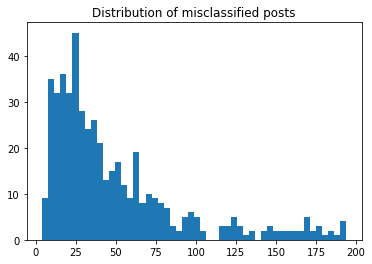

In [142]:
plt.hist(x = df_doublecheck['post_length'], bins = 50)
plt.title('Distribution of misclassified posts');

Distribution of misclassified post length looks similar to the overall distribution of word length, length of post has little effect on misclassification.

Misclassification seems to occur when the post is made up of ambiguous words ( words with coefficients close to 0 ) and 1 or 2 words with strong correlation ( words with high absolute coefficients ).

### 11. Conclusion

#### Can we accurately classify a post to the correct subreddit?

Recalling our problem statement: <br><br>
'Men In Black (MIB) is a government entity that researches & monitors the sentiment of people on aliens, whether conspiracies that are made are a little too close to things that the people should not know about. They are requesting us, the Reddit Data Science team to create a model to classify reddit posts and identify the key words that differentiates the post from "Aliens" to "Space". This would facilitate MIB's intelligence collection efforts about sentiments from ordinary citizens. This information can also be useful for other associations to promote its marketing effort on social media, events and podcasts, that in turn can feed information to the mainstream.<br><br>
All the models trained were able to classify the posts accurately, with a F1 score between 89% to 91% and an AUC of 96% to 97%, but we chose Tfidf vectorizer and Logistic Regression model as it is easier to interpret. The model makes its predictions by using the coefficients of each word in the post and calculates the odds of it belonging to alien subreddit or it not belonging to alien subreddit.<br><br>
The top words with the highest 'weights' for alien subreddit are:
- alien
- ufo
- specie(s)
- human
- extraterrestrial
 <br><br>
 
The more the above listed words appear in a post, the higher the chance if it belonging to alien subreddit. We can also infer from these words that the topics on r/aliens are on aliens, ufos and extraterrestrials.<br><br>

The top words with the highest 'weights' for space subreddit are:
- space
- telescope
- launch
- moon
- jwst
 <br><br>
 
The more the above listed words appear in a post, the higher the chance if it belonging to alien subreddit. We can infer from these words that the topics on r/space are about space, James Webb Space Telescope and perhaps the launching of rockets to the moon.<br><br>

With this model, MIB will be able to classify reddit posts and identiy the top words.
<br><br>
The subsidiaries of MIB, secondary stakeholders, can then use the top words and do SEO on them, to increase the visibality of their projects. 

#### Limitations of our approach

- We used the textual content of the post to train our model, as it is only able to process text, and left out videos, images and links to other websites.
- The data scrapped from reddit is from 1 Jan 2022. It is not an indicator of future or past. The results generated from the model only work for the period of 1 Jan 2022.
- There are posts that are more ambiguous in nature, which our model has a hard time predicting. Misclassification seems to occur when the post is made up of ambiguous words ( words with coefficients close to 0 ) and 1 or 2 words with strong correlation ( words with high absolute coefficients ).

#### Future Considerations

- Sentiment analysis could be done on the reults of the model, allowing MIB to have a general idea and plan for their policies.
- Process information from text in image and transcript of videos could be added to the data to train a better model, as most of the data lost was through images and videos.